title: "Correlations Between Measures (BPE)"

author: "Chris Bentz"

date: "June 30, 2020"

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install.packages("ggplot2")
install.packages("gridExtra")
install.packages("GGally")
install.packages("Hmisc")
install.packages("ggrepel")

In [ ]:
%%R
library(ggplot2)
library(gridExtra)
library(GGally)
library(Hmisc)
library(ggrepel)


The results of BPE related analyses are loaded as a csv file:

In [ ]:
%%R
file1 <- read.csv("variables.csv")

# Plot correlations

We here plot correlations between measures (in the columns of the csv files). The Spearman correlation coefficient is reported instead of the Pearson correlation coefficient. This is because we are only interested whether there is a correlation between the rankings of values, regardless of whether this is a linear relationship. We therefore also use the local regression smoothers in the plots (loess) rather than linear models (lm).

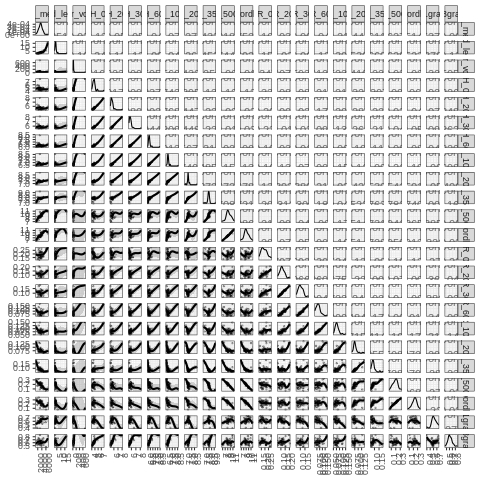

In [ ]:
%%R

file1.short <- file1[, 3:ncol(file1)]

file1.plot <- ggpairs(file1.short, 
                        lower = list(continuous = wrap("smooth_loess", alpha = 0.3, lwd = 0.5, size = 2)), 
                        upper = list(continuous = wrap('cor', method = "spearman"))) +
                        theme_bw() +
                        theme(axis.text.x = element_text(angle = 90, hjust = 1))
print(file1.plot)
ggsave("file1_correlation_plot.pdf", file1.plot, dpi = 300, scale = 1, width = 17, height = 17, device = cairo_pdf)

#Significant Correlations
Not all of the correlations displayed above are going to be significant. We here only select the ones still significant after correcting for multiple testing. Therefore, first calculate Spearman correlations and uncorrected p-values using the function rcorr(). These are then stored in a data frame where the first two columns give the names of the correlated measures. 

In [ ]:
%%R
#transform the data frame to a matrix
file1.matrix <- as.matrix(file1.short)
#apply the rcorr function to this matrix to get matrices of Spearman correlations and uncorrected p-values
file1.cor <- rcorr(file1.matrix, type = "spearman")$r
file1.pvalues <- rcorr(file1.matrix, type = "spearman")$P
file1.n <- rcorr(file1.matrix, type = "spearman")$n
#convert these matrices to a data frame again
file1.df <- data.frame(row = rownames(file1.pvalues)[row(file1.pvalues)[upper.tri(file1.pvalues)]], 
           col = colnames(file1.pvalues)[col(file1.pvalues)[upper.tri(file1.pvalues)]], 
           pvalue = file1.pvalues[upper.tri(file1.pvalues)],
           corr = file1.cor[upper.tri(file1.cor)],
           num = file1.n[upper.tri(file1.n)])
head(file1.df)

          row         col       pvalue        corr num
1 final_merge word_length 3.463896e-14  0.85124243  47
2 final_merge  char_vocab 8.132401e-01 -0.03540287  47
3 word_length  char_vocab 4.742391e-01 -0.10696099  47
4 final_merge         H_0 3.834121e-01 -0.13010154  47
5 word_length         H_0 9.887971e-02 -0.24364015  47
6  char_vocab         H_0 3.958188e-06  0.61645900  47


##Bonferroni Correction
Apply the so-called Bonferroni correction, namely, multiply the p-values by the overall number of tests done. Arguably, this is the simplest, and also most conservative method for correcting the p-values. There are less-conservative alternatives such as the Holm-Bonferroni correction. Since the approach here is exploratory, and we have many measures and hence pairwise correlations anyways, we decided to go for the most conservative method. 

In [ ]:
%%R
# compute the overall number of tests, i.e. multiply the number of measures in each file with the same number -1 (don't count tests for a measure with itself), and add them up.
n.test <- ncol(file1.short)*(ncol(file1.short) - 1)
# add corrected pvalues to data frames
file1.df$pvalue.correct <- file1.df$pvalue*n.test

Remove all correlations which are not significant anymore. And then order them from highest to lowest coefficient.

In [ ]:
%%R
file1.df <- file1.df[file1.df$pvalue.correct < 0.05, ]
file1.df <- file1.df[order(-file1.df$corr), ]
#Correlations still significant after Bonferroni correction for File 1:
print(file1.df)

            row         col       pvalue       corr num pvalue.correct
66       H_5000 H_wordlevel 0.000000e+00  0.9855458  47   0.000000e+00
15         H_20        H_30 0.000000e+00  0.9798797  47   0.000000e+00
210      R_5000 R_wordlevel 0.000000e+00  0.9676226  47   0.000000e+00
105        R_20        R_30 0.000000e+00  0.9660037  47   0.000000e+00
21         H_30        H_60 0.000000e+00  0.9444958  47   0.000000e+00
10          H_0        H_20 0.000000e+00  0.9167438  47   0.000000e+00
28         H_60       H_100 0.000000e+00  0.9128122  47   0.000000e+00
14          H_0        H_30 0.000000e+00  0.9093432  47   0.000000e+00
120        R_30        R_60 0.000000e+00  0.9043710  47   0.000000e+00
20         H_20        H_60 0.000000e+00  0.9020583  47   0.000000e+00
136        R_60       R_100 0.000000e+00  0.8999769  47   0.000000e+00
45        H_200       H_350 1.554312e-15  0.8718779  47   7.864820e-13
237        H_30      H3gram 6.661338e-15  0.8623959  47   3.370637e-12
119   